# Image classification to predict deforestation type

Event: [Schneider Electric European Hackaton](https://nuwe.io/dev/event/schneider-electric-european-hackathon)

Category: Data Science challenge

Challenge: [Zero deforestation mission](https://nuwe.io/dev/challenges/data-science-se-european)

Author: [Sergi Salido](https://github.com/SergiSalido)

Date: 2022-11-19

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/SergiSalido/SE_Hackaton_DataScience_ZeroDeforestationMission/blob/main/main.ipynb)


## Challenge goal
The challenge consists in creating an image classification model, which from a given dataset, **predicts the class of deforestation appears in the image with the objective of early detection of this type of actions in protected lands**.

## Tasks
1. Create an image classification predictive model
1. Train the model with the training images
1. Find the model that maximizes the F1-score (macro.)
1. Test the model to classify the testing images
1. Evaluate the F1-score of the model with predictions

## Datasets
The following files are provided to complete the challenge:
* [train.csv](https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train.csv): A training CSV file that relates the ID of the images to their features and classes.
* [test.csv](https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/test.csv): A testing CSV file that relates the ID of the images to their features.
* [train_test_data.zip](https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip): A zip file containing a few thousand training and testing aerial images of different deforested areas. This zip file has a weight of 309MB.

These are the attributes to be able to make the classifications:

* **latitude**: Where the photo latitude was taken.
* **longitude**: Where the photo longitude was taken.
* **year**: Year, in which the photo was taken.
* **example_path**: Path where the sample image is located.
* **label**: In this column you will have the following categories:
  * **Plantation**: Encoded with number 0, Network of rectangular plantation blocks, connected by a well-defined road grid. In hilly areas the layout of the plantation may follow topographic features. In this group you can find: Oil Palm Plantation, Timber Plantation and Other large-scale plantations.
  * **Grassland/Shrubland**: Encoded with number 1, Large homogeneous areas with few or sparse shrubs or trees, and which are generally persistent. Distinguished by the absence of signs of agriculture, such as clearly defined field boundaries.
  * **Smallholder Agriculture**: Encoded with number 2, Small scale area, in which you can find deforestation covered by agriculture, mixed plantation or oil palm plantation.

The neural network model will predict the class (0, 1, 2) of the deforested area.

# Source code
The source code is divided into the following steps:
<nav>
* [Importing libraries](#1)
* [Loading data](#1)
* [Exploring data](#1)
* [Defining the model structure](#1)
* [Training the model](#1)
* [Making predictions](#1)
</nav>

<a id="1"></a>
## Importing libraries

In [ ]:
import os
import pandas
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from PIL import Image

import keras
from keras.models import Sequential
import keras.layers as layers
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

<a id="2"></a>
## Loading data

In [ ]:
# Read the training dataset
train_df = pandas.read_csv('https://raw.githubusercontent.com/SergiSalido/SE_Hackaton_DataScience_ZeroDeforestationMission/main/datasets/train.csv')

# Read the testing dataset
test_df = pandas.read_csv('https://raw.githubusercontent.com/SergiSalido/SE_Hackaton_DataScience_ZeroDeforestationMission/main/datasets/test.csv')

In [ ]:
# Download the training and testing images zip file
!wget https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip &> /dev/null
# Unzip the zip file
!unzip train_test_data.zip &> /dev/null
# Removes the zip file
!rm train_test_data.zip

^C


## Exploring the data
Exploratory Data Analysis (EDA) of the given datasets.

In [ ]:
# Describe the training dataset
train_df.describe()

,label,latitude,longitude,year
count,1714.000000,1714.000000,1714.000000,1714.000000
mean,0.882147,-0.458578,108.696539,2009.770712
std,0.933952,2.146293,9.136482,4.206081
min,0.000000,-8.318462,95.902427,2001.000000
25%,0.000000,-1.916629,101.627073,2007.000000
50%,0.000000,-0.417759,104.104074,2010.000000
75%,2.000000,1.062408,114.274851,2013.000000
max,2.000000,5.014370,140.900849,2016.000000


In [ ]:
# Describe the testing dataset
test_df.describe()

,latitude,longitude,year
count,635.000000,635.000000,635.000000
mean,-0.359479,108.772788,2009.617323
std,2.247732,9.153662,4.473548
min,-8.880926,95.757681,2001.000000
25%,-1.792243,101.609698,2006.000000
50%,-0.204938,104.103571,2010.000000
75%,1.133431,114.849800,2013.000000
max,5.152187,140.987545,2016.000000


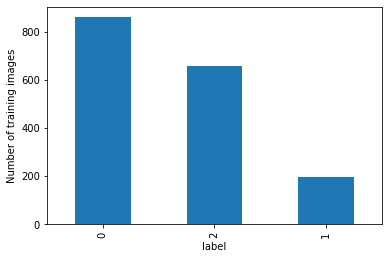

In [ ]:
train_df['label'].value_counts().plot(kind='bar', xlabel="label", ylabel="Number of training images")

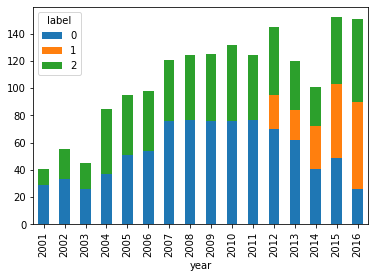

In [ ]:
train_df.groupby(['year', 'label']).size().unstack().plot(kind='bar', stacked=True)

In [ ]:
def check_same_image_size(directory, img_height, img_width):
  for file in os.listdir(directory):
    img = Image.open(directory + file)
    if img.height != img_height or img_width != img_width:
      return False
  return True

img_height = 332
img_width  = 332

print(check_same_image_size('train_test_data/train/', img_height, img_width))
print(check_same_image_size('train_test_data/test/', img_height, img_width))

True
True


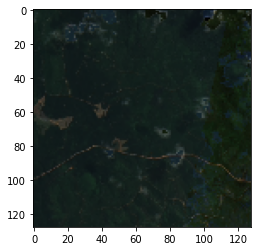

In [108]:
plt.imshow(tf.keras.utils.load_img(train_df['example_path'][0], target_size=(128,128)))

## Preprocessing data

In [ ]:
# Convert images
def convert_images(df, target_size_img_height, target_size_img_width):
  images = []
  for ind in df.index:
    img = tf.keras.utils.load_img(df['example_path'][ind], target_size=(target_size_img_height, target_size_img_width, 3))
    img = tf.keras.utils.img_to_array(img)
    img = img / 255
    images.append(img)
  return np.array(images)

In [ ]:
target_size_img_height  = 128
target_size_img_width   = 128

X = convert_images(train_df, target_size_img_height, target_size_img_width)

In [ ]:
# As it is a multi-class classification problem (3 classes), one-hot encode the target variable
y = to_categorical(train_df['label'].values)

In [ ]:
# Creating a validation set from the training data
X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42, test_size=0.2)

## Defining the model’s architecture
CNN Image Classification


In [ ]:
num_classes = 3

# Image data augmentation
data_augmentation = keras.Sequential(
  [layers.RandomFlip("horizontal", input_shape=(target_size_img_height, target_size_img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)]
)

# Create the model architecture
model = Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (128, 128, 3)))
model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='softmax'))

# Compiling the CNN
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

display(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 124, 124, 32)      18464     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 123008)            0         
                                                                 
 dense_6 (Dense)             (None, 3)                 369027    
                                                     

None

## Training the model

Epoch 1/5
43/43 [==============================] - 76s 2s/step - loss: 0.9468 - accuracy: 0.4887 - val_loss: 0.9577 - val_accuracy: 0.5423
Epoch 2/5
43/43 [==============================] - 83s 2s/step - loss: 0.9223 - accuracy: 0.5536 - val_loss: 1.0421 - val_accuracy: 0.5102
Epoch 3/5
43/43 [==============================] - 77s 2s/step - loss: 0.8395 - accuracy: 0.6054 - val_loss: 0.8629 - val_accuracy: 0.5831
Epoch 4/5
43/43 [==============================] - 74s 2s/step - loss: 0.6983 - accuracy: 0.6922 - val_loss: 0.9746 - val_accuracy: 0.5685
Epoch 5/5
43/43 [==============================] - 73s 2s/step - loss: 0.5321 - accuracy: 0.8067 - val_loss: 0.8780 - val_accuracy: 0.6035


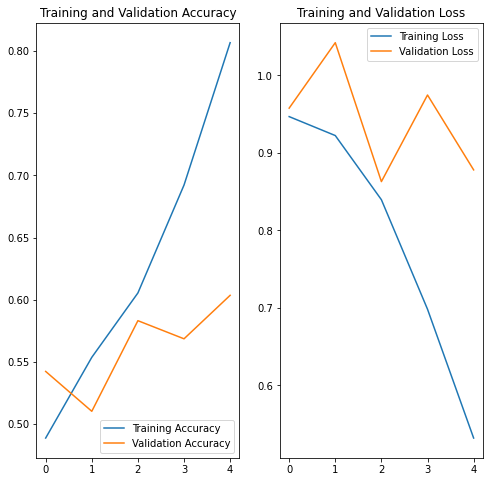

In [ ]:
# Train the model on the training set images and validate it using the validation set
epochs = 5
history = model.fit(X_train, y_train,
                    validation_data = (X_validation, y_validation),
                    epochs = epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluating the model

## Testing the model

In [ ]:
X_test = convert_images(test_df, target_size_img_height, target_size_img_width)

In [ ]:
y_predict = model.predict(X_test) 
test_classes = np.argmax(y_predict, axis=1)

20/20 [==============================] - 7s 348ms/step


In [ ]:
test_classes

array([0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2,
       0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0,
       0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0,

In [109]:
predictions_df = test_df
predictions_df['target'] = test_classes
predictions_df['name'] = predictions_df['example_path'].str.replace("train_test_data/test/", "").str.replace(".png", "")
predictions_df = predictions_df[['target', 'name']]
predictions_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [110]:
predictions_df

,target,name
0,0,69
1,2,469
2,0,6
3,2,351
4,2,1001
...,...,...
630,2,968
631,2,54
632,2,494
633,0,287


## Save results

In [ ]:
predictions_df.to_csv('predictions.csv' )

In [ ]:
predictions_df = predictions_df.set_index('name')
predictions_df.to_json('predictions.json')